In [2]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dropout, Dense, Bidirectional, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [3]:
train_df = pd.read_csv("./content/UNSW_NB15_training-set.csv")
test_df = pd.read_csv("./content/UNSW_NB15_testing-set.csv")

In [4]:
# Drop unnecessary columns
drop_cols = ['id', 'attack_cat']
train_df.drop(columns=drop_cols, inplace=True)
test_df.drop(columns=drop_cols, inplace=True)

# Combine for consistent label encoding
combined = pd.concat([train_df, test_df], axis=0)

In [5]:
categorical_cols = ['proto', 'service', 'state']
encoder = LabelEncoder()
for col in categorical_cols:
    combined[col] = encoder.fit_transform(combined[col])


In [6]:
# Split again
train = combined.iloc[:len(train_df)]
test = combined.iloc[len(train_df):]

# Separate features and labels
X_train = train.drop(columns='label').astype('float32')
y_train = train['label'].values
X_test = test.drop(columns='label').astype('float32')
y_test = test['label'].values

# Normalize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
# Reshape for GRU
features = X_train_scaled.shape[1]
timesteps = 1
X_train_rnn = X_train_scaled.reshape(X_train_scaled.shape[0], timesteps, features)
X_test_rnn = X_test_scaled.reshape(X_test_scaled.shape[0], timesteps, features)

# K-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_accuracies, fold_precisions, fold_recalls, fold_f1s = [], [], [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_rnn, y_train), 1):
    x_fold_train, x_fold_val = X_train_rnn[train_idx], X_train_rnn[val_idx]
    y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

    print(f"\nFold {fold} - Training Shape: {x_fold_train.shape}, Validation Shape: {x_fold_val.shape}")

    class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                      classes=np.unique(y_fold_train),
                                                      y=y_fold_train)
    class_weights = dict(enumerate(class_weights))

    model = Sequential([
        Bidirectional(GRU(64, return_sequences=True), input_shape=(timesteps, features)),
        BatchNormalization(),
        Dropout(0.4),
        GRU(32),
        BatchNormalization(),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

    model.fit(x_fold_train, y_fold_train,
              epochs=50,
              batch_size=128,
              validation_data=(x_fold_val, y_fold_val),
              callbacks=[early_stop, reduce_lr],
              class_weight=class_weights,
              verbose=0)

    y_pred = (model.predict(x_fold_val) > 0.5).astype(int).ravel()

    acc = accuracy_score(y_fold_val, y_pred)
    prec = precision_score(y_fold_val, y_pred, zero_division=0)
    rec = recall_score(y_fold_val, y_pred, zero_division=0)
    f1 = f1_score(y_fold_val, y_pred, zero_division=0)

    fold_accuracies.append(acc)
    fold_precisions.append(prec)
    fold_recalls.append(rec)
    fold_f1s.append(f1)

    print(f"Fold {fold} Results:")
    print(confusion_matrix(y_fold_val, y_pred))
    print(classification_report(y_fold_val, y_pred, zero_division=0))
    print("-" * 50)

# Final metrics
print("\nAverage Metrics Over All Folds:")
print("Avg Accuracy :", np.mean(fold_accuracies))
print("Avg Precision:", np.mean(fold_precisions))
print("Avg Recall   :", np.mean(fold_recalls))
print("Avg F1 Score :", np.mean(fold_f1s))

# Final model training and evaluation on test set
print("\n--- Final Evaluation on Test Set ---")
model.fit(X_train_rnn, y_train,
          epochs=50,
          batch_size=128,
          validation_split=0.1,
          callbacks=[early_stop, reduce_lr],
          class_weight=class_weights,
          verbose=0)

y_test_pred = (model.predict(X_test_rnn) > 0.5).astype(int).ravel()
print("Test Set Classification Report:")
print(confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, zero_division=0))



Fold 1 - Training Shape: (65865, 1, 42), Validation Shape: (16467, 1, 42)




515/515 [==============================] - 3s 2ms/step
Fold 1 Results:
[[7185  215]
 [ 424 8643]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      7400
           1       0.98      0.95      0.96      9067

    accuracy                           0.96     16467
   macro avg       0.96      0.96      0.96     16467
weighted avg       0.96      0.96      0.96     16467

--------------------------------------------------

Fold 2 - Training Shape: (65865, 1, 42), Validation Shape: (16467, 1, 42)
515/515 [==============================] - 1s 1ms/step
Fold 2 Results:
[[7229  171]
 [ 397 8670]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      7400
           1       0.98      0.96      0.97      9067

    accuracy                           0.97     16467
   macro avg       0.96      0.97      0.97     16467


In [8]:
# Final metrics
print("\nAverage Metrics Over All Folds:")
print("Avg Accuracy :", np.mean(fold_accuracies))
print("Avg Precision:", np.mean(fold_precisions))
print("Avg Recall   :", np.mean(fold_recalls))
print("Avg F1 Score :", np.mean(fold_f1s))



Average Metrics Over All Folds:
Avg Accuracy : 0.9627605161922916
Avg Precision: 0.9756882434143466
Avg Recall   : 0.9562120129746662
Avg F1 Score : 0.9658446407095436


Average Accuracay: 0.9628
Average Precision: 0.9757
Average Recall: 0.9562
Average F1-score: 0.9658


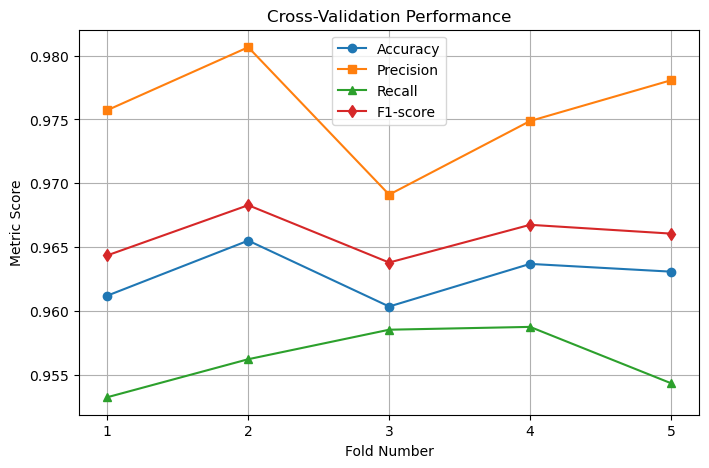

In [10]:
import matplotlib.pyplot as plt
if fold_accuracies:
    avg_acc = np.mean(fold_accuracies)
    avg_prec = np.mean(fold_precisions)
    avg_rec = np.mean(fold_recalls)
    avg_f1 = np.mean(fold_f1s)

    print(f"Average Accuracay: {avg_acc:.4f}")
    print(f"Average Precision: {avg_prec:.4f}")
    print(f"Average Recall: {avg_rec:.4f}")
    print(f"Average F1-score: {avg_f1:.4f}")

    #Plot performance across folds
    plt.figure(figsize=(8,5))
    plt.plot(range(1, len(fold_accuracies) + 1), fold_accuracies, marker='o', label='Accuracy')
    plt.plot(range(1, len(fold_precisions) + 1), fold_precisions, marker='s', label='Precision')
    plt.plot(range(1, len(fold_recalls) + 1), fold_recalls, marker='^', label='Recall')
    plt.plot(range(1, len(fold_f1s) + 1), fold_f1s, marker='d', label='F1-score')

    plt.xticks(range(1, len(fold_accuracies) + 1))
    plt.xlabel('Fold Number')
    plt.ylabel('Metric Score')
    plt.title('Cross-Validation Performance')
    plt.legend()
    plt.grid()
    plt.show()
else:
    print("No valid folds with both classes. Check dataset balance.")
